In [1]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import rebound

c1 = '#990099'
c2 = '#4d0099'

%matplotlib inline

# Información inicial para que el código funcione

En la siguiente celda deben poner la información sobre la resonancia del objeto que analizarán.

Primero deben cambiar "indPlaneta" que corresponde al índice en la simulación del planeta que esté en resonancia
con el objeto que eligieron. Los índices son:
1. Mercurio
2. Venus
3. Tierra
4. Marte
5. Júpiter
6. Saturno
7. Urano
8. Neptuno

A "indObjeto" no lo muevan, le puse 9 porque es el que le corresponde en la simulación al "objeto en estudio".

Después cambien el número de periodos necesarios para observar la resonancia, por ejemplo: 
El asteroide que quiero estudiar, 1685 Toro (con nombre provisional 1948 OA), está en resonancia 5:13 con Venus (es decir, Toro da 5 vueltas al Sol mientras Venus da 13). Por ello, en numObjeto pongo 5 (las vueltas que debe dar Toro) y en numPlaneta pongo 13 (las que da Venus) para que el diagrama se vea completo. 
El código más adelante solito con esta información obtiene cuál es el tiempo ideal para la simulación :) 

In [2]:
"""Información sobre la resonancia"""

# Objeto a analizar 
Objeto = '1948 OA'

# Índices
indObjeto  = 9  # Objeto de estudio
indPlaneta = 2  # Planeta

# Número de periodos necesarios para observar la resonancia
numObjeto  = 5  # Objeto de estudio
numPlaneta = 13 # Planeta

De aquí en adelante el código funciona bien solito y no deben modificarlo (salvo que les de curiosidad hacer cambios, claro). 

# Inicializando la simulación

In [3]:
"""Inicializando la simulación"""

sim = rebound.Simulation()        # En "sim" alojaremos la info de la simulacion
sim.units = ('AU', 'yr', 'Msun')  # Unidades que queremos usar
sim.integrator = "ias15"          # Integrador de REBOUND

In [4]:
"""Cuerpos a incluir en la simulación"""

Sol = ['Sun']
sim.add(Sol)

Planetas = ['Mercury','Venus','Earth','Mars','Jupiter','Saturn','Uranus','Neptune']
sim.add(Planetas)

sim.add(Objeto)

sim.move_to_com()

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Mercury'... Found: Mercury Barycenter (199).
Searching NASA Horizons for 'Venus'... Found: Venus Barycenter (299).
Searching NASA Horizons for 'Earth'... Found: Earth-Moon Barycenter (3).
Searching NASA Horizons for 'Mars'... Found: Mars Barycenter (4).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Searching NASA Horizons for 'Uranus'... Found: Uranus Barycenter (7).
Searching NASA Horizons for 'Neptune'... Found: Neptune Barycenter (8).
Searching NASA Horizons for '1948 OA'... Found: 1685 Toro (1948 OA).


/opt/anaconda3/lib/python3.7/site-packages/rebound/horizons.py:140: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


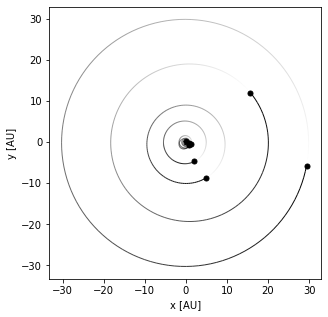

In [5]:
"""Gráfica con las órbitas"""

fig = rebound.OrbitPlot(sim, unitlabel="[AU]")
plt.savefig('orbit.pdf',bbox_inches='tight');

El tiempo "ideal" de la simulación estará determinado por el valor máximo entre:
- El producto del periodo del planeta con el número de vueltas que da para que se vea la resonancia. 
- El producto del periodo del objeto con el número de vueltas que da para que se vea la resonancia. 

In [6]:
"""Determinación del tiempo de la simulación"""

periodoPlaneta = sim.particles[indPlaneta].P   # Periodo orbital del planeta
periodoObjeto  = sim.particles[9].P            # Periodo orbital del objeto
 
tSim = np.maximum(numPlaneta*periodoPlaneta, numObjeto*periodoObjeto) # Tiempo de la simulación
N = 5000                                                              # Número de salidas
tiempos = np.linspace(0., tSim, N)                                    # Momentos en que generará las salidas

# Haciendo la simulación

In [7]:
"""Arreglos para almacenar la información"""

t = []
xPlaneta, yPlaneta, lambdaPlaneta = [],[],[] # Datos del Planeta
xObjeto, yObjeto = [],[]                     # Datos del Objeto

In [8]:
"""Haciendo la integración"""

for i,tiempo in enumerate(tiempos):
    
    sim.integrate(tiempo)
    t.append(tiempo)

    # Con este ciclo guardaremos la información de la posición
    j = 0
    for p in sim.particles:
        if j == indPlaneta:  # Posición del Planeta
            xPlaneta.append(p.x)
            yPlaneta.append(p.y)
        if j == indObjeto:   # Posición del Objeto
            xObjeto.append(p.x)
            yObjeto.append(p.y)
        j = j + 1
    
    # Con este ciclo guardaremos la longitud media
    k = 1
    for o in sim.calculate_orbits():
        if k == indPlaneta:  # Longitud media del Planeta
            lambdaPlaneta.append(o.l)
        k = k + 1

# Análisis

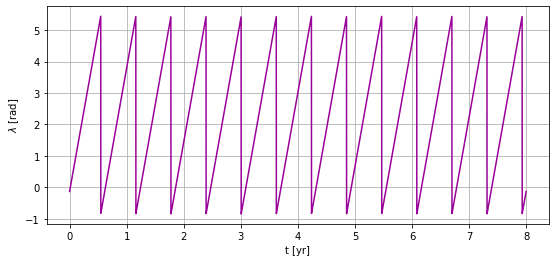

In [9]:
fig, ax = plt.subplots(figsize=(9,4))
ax.grid(True)
ax.plot(t, lambdaPlaneta, color = c1)
ax.set_xlabel('t [yr]')
ax.set_ylabel(r'$\lambda$ [rad]')
plt.savefig('lambda1.pdf',bbox_inches='tight');

In [10]:
"""Construimos la recta"""

N = len(lambdaPlaneta)
l = []
i,k = 0,0

for i in range(1, N+1):
    l1 = lambdaPlaneta[i-1]
    if i < N:
        l2 = lambdaPlaneta[i]
        l.append(l1 + k * np.pi)
        if l1 > l2:
            k = k + 2
    else:
        l.append(l1 + k * np.pi)

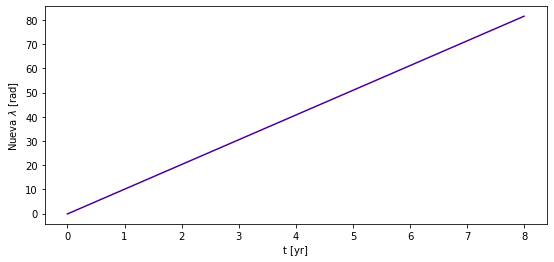

In [11]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(t, l, color = c2)
ax.set_xlabel('t [yr]')
ax.set_ylabel(r'Nueva $\lambda$ [rad]')
plt.savefig('lambda2.pdf',bbox_inches='tight');

In [12]:
"""Calculando la pendiente por mínimos cuadrados"""

i = 0
X, Y, XY, X2 = 0., 0., 0., 0.

for i in range(0,N):
    X = X + t[i]        # Suma de las x (el tiempo)
    Y = Y + l[i]        # Suma de las y (la longitud media)
    XY = XY + t[i]*l[i] # Suma de x*y (t * lambda)
    X2 = X2 + t[i]**2   # Suma de x^2 (t^2)

m = (N*XY - X*Y)/(N*X2 - X**2)  # Valor de la pendiente

In [13]:
"""Haciendo la rotación"""
xPlanetaRot, yPlanetaRot = [], []
xObjetoRot, yObjetoRot = [], []

i = 0
for i in range(0,N):
    cos = np.cos(m*t[i])
    sen = np.sin(m*t[i])
        
    xPlanetaRot.append(+ xPlaneta[i] * cos + yPlaneta[i] * sen)
    yPlanetaRot.append(- xPlaneta[i] * sen + yPlaneta[i] * cos)
    
    xObjetoRot.append(+ xObjeto[i] * cos + yObjeto[i] * sen)
    yObjetoRot.append(- xObjeto[i] * sen + yObjeto[i] * cos)

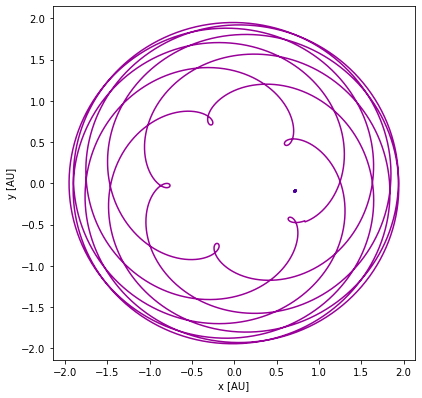

In [14]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
ax.plot(xObjetoRot, yObjetoRot, color = c1)
ax.plot(xPlanetaRot, yPlanetaRot, color = c2)
ax.set_xlabel(r'x [AU]')
ax.set_ylabel(r'y [AU]')
plt.savefig('resonance.pdf',bbox_inches='tight');